# Youtube Analysis 
Proof of concept project for analysing the sentiment of videos returned by searching for a key word (i.e. product name). 

Initial implimentation uses NLP to assess the polarity of comments for each video combining this with other metrics to return an overall sentiment score.

Future additions will integrate a company product list and security identifiers to link companies/ tickers to sentiment scores, allowing for statistical assessment of it's predictive power with regards to stock price.


## Setup

1. Create Youtube Data API key as per the instructions [here](https://developers.google.com/youtube/v3/getting-started) 

2. Create `.env` file containing the key as follows: `YT_API_KEY=[key]`
   
3. Finally, after installing SpaCy in your environment, ensure the language library is installed by running the below command in the terminal:

```shell
                                        spacy download en_core_web_sm
```

#### Dependencies

In [1]:
import os
import pandas as pd

import Library.database
from Library.data_api import youtube
from Library.helpers import dict_search, min_max_scaler

##### Import Google Data API Key and Initiate Youtube API Class Instance


In [2]:
# Import env variables and set API key
from dotenv import load_dotenv # Needed to ensure .env file imported into jupyter env
load_dotenv() 

DEVELOPER_KEY = os.environ.get('YT_API_KEY')


# Create YouTube Data API object
yt = youtube(DEVELOPER_KEY)

## Search
Run a search using the key term, returning the IDs of relevant videos ordered by upload date.

In [3]:
# Enter keyword below:
keyword = 'macbook' # Macbook as an example
region = 'US'

In [4]:
# Use search method to retrieve IDs
response = yt.search(keyword, order='date', regionCode=region) #Start 
raw_ids = dict_search(response, ["videoId"], list_depth=2)
ids = [row['videoId'] for row in raw_ids]

In [5]:
# Retrieve general information for each video
raw_stats = yt.video_stats(ids)
clean_stats = dict_search(raw_stats, [
    "id", 
    "title",
    "decription", 
    "channelTitle",
    "channelId", 
    "categoryId", 
    "viewCount", 
    "likeCount", 
    "commentCount", 
    "publishedAt"], list_depth=2)
stats_df = pd.DataFrame(clean_stats)
stats_df.head(5)

,id,publishedAt,channelId,title,channelTitle,categoryId,viewCount,likeCount,commentCount
0,CANQoFSfAO4,2022-02-10T11:00:11Z,UCJsk0LDYS5Y4_A4TVOcGa-w,M2 MacBook Pro! WAS ändert sich? iOS 15.4 verb...,youmac,28,85,11,2
1,QAvMpUQzzJY,2022-02-10T10:30:10Z,UC5D3nqqGu8dTYWuL2D3AhhA,【寝起き開封】底辺YouTuber、ついに『新型MacBook Pro 14インチ』を買う。,けたごら,22,56,5,4
2,d67-xpKnAMo,2022-02-10T09:57:10Z,UCmMoGrEd9tVC-yOfvZqcRtg,Adobe Indesign 2021 Macbook,Doris Burns,22,0,1,0
3,dFwH4rQ3nFs,2022-02-10T09:49:29Z,UC-_r3ybLeGdNfca0UriJ6XA,Apple MacBook Pro 14 M1 Pro chip - Unboxing - ...,Dev Next Level,10,331,63,20
4,QZtlA9y7ESk,2022-02-10T09:45:10Z,UC1beJvjmn2aFc9tInLyMVqg,Apple MacBook Laptop Repairing course ! MacBoo...,Rajkumar Kushwaha,27,290,23,3


In [6]:
# Retrieve top level comment threads for each video to be used to guage polarity
raw_comments = yt.commentThread(ids)
comments = dict_search(raw_comments, [
    "videoId",
    "textDisplay",
    "publishedAt"
    ], list_depth=2)
comments_df = pd.DataFrame(comments)

In [7]:
# Rename id, comments and comment publishedAt columns and merge with stats dataframe
stats_df.rename(columns={'id':'videoId'}, inplace=True)
comments_df.rename(columns={'textDisplay':'comment', 'publishedAt':'commentDate'}, inplace=True)
merged_df = pd.merge(stats_df, comments_df, how='left', on='videoId')
merged_df['comment'].fillna('', inplace=True)

In [8]:
# Retrieve channel stats for each video and merge with other dataframe
raw_channelStats = yt.channel(stats_df['channelId'].to_list(), part="statistics")
channelStats = dict_search(raw_channelStats, [
    "id", 
    "subscriberCount", 
    "videoCount"
    ], list_depth=2)
channel_df = pd.DataFrame(channelStats)

# Rename ID column and merge
channel_df.rename(columns={'id':'channelId'}, inplace=True)
merged_df = pd.merge(merged_df, channel_df, how='left', on='channelId')

## Sentiment Analysis
Initial data munging is done to clean up the raw data for easier analysis

In [9]:
# Import sentiment object for analysis
from Library.analysis import sentiment

# Analyse each comment and give polarity score
# 1: Positive, 0: Neutral, -1: Negative
comment_list = merged_df['comment'].astype(str)
s = sentiment(comment_list)

merged_df['comment_polarity'] = s.polarity()

In [10]:
# amend data type in count columns from string to integers
merged_df[['likeCount', 'viewCount', 'commentCount', 'subscriberCount']] = merged_df[['likeCount', 'viewCount', 'commentCount', 'subscriberCount']].astype(int)
for column in ['publishedAt', 'commentDate']:
    merged_df[column] = merged_df[column].astype('datetime64').dt.normalize()

df = merged_df.copy()
df.drop_duplicates(inplace=True)
df.dropna(axis=0, how='all')

# Polarity scaled by comment count
df['comment_polarity'] /= df['commentCount']

df['view_sub_ratio'] = df['viewCount'] / df['subscriberCount']
df['like_view_ratio'] = df['likeCount'] / df['viewCount']
df['comment_view_ratio'] = df['commentCount'] / df['viewCount']

### Create Comment Polarity Time Series
Exploratory analysis of comment sentiment (all comments across all videos).<br> Polarity for each day is taken as the mean polarity score, with the time series being normalised to easily analyse the trend. <br>Volume of comments over time has then been overlayed to help assess the strength of the signal.


In [11]:
import matplotlib.pyplot as plt

# Sentiment time series
time_series = df.copy()
time_series = time_series.groupby('commentDate').agg(polarity=('comment_polarity','mean'), count = ('commentDate','size')).reset_index()
time_series.fillna(0, inplace=True)

In [12]:
# Normalise comment polarity
time_series['polarity'] = min_max_scaler(time_series['polarity'])
time_series.set_index('commentDate', inplace=True)

Text(0, 0.5, 'Comments')

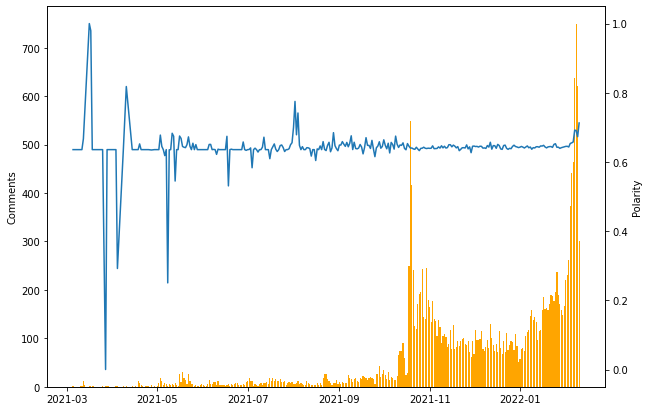

In [13]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax2 = ax1.twinx()
ax2.plot(time_series['polarity'])
ax2.set_ylabel('Polarity')
ax1.bar(time_series.index, time_series['count'], color='orange')
ax1.set_ylabel('Comments')

### Creating a sentiment score
We assess that sentiment can be summarised by: <br>
<br>
$\text{Sentiment} = \dfrac{\sum\text{Comment Polarity}}{\text{Video comment Count}} \times \dfrac{\text{Video Views}}{\text{Channel Subscribers}}$

<AxesSubplot:xlabel='publishedAt'>

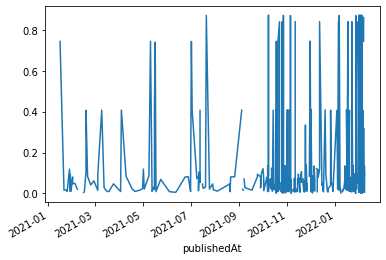

In [31]:
# Groupby, summing polarity of comments for each video ID
df = df.groupby(['videoId','view_sub_ratio', 'like_view_ratio', 'comment_view_ratio', 'subscriberCount', 'publishedAt']).agg({'comment_polarity':['sum']}).reset_index()
df.columns = df.columns.droplevel(1)
df.set_index('publishedAt', inplace=True)

# Create video sentiment score
df['sentiment'] = df['comment_polarity'] * df['view_sub_ratio']

df['rolling_1m'] = df['sentiment'].rolling(30).mean()
df['rolling_1m'].plot()

## Stock Price Predictive Power

\*\*TODO\*\*